In [11]:
#################
#
# Met Office Climate Data Hackathon 5-6th May 2022.
# Hannah Bloomfield hannah.bloomfield@bristol.ac.uk
# Script to create new exposure dataset (messy!)
# TO DO: update the reading of lats/lons so that it's not on the rotated grid (makes minimal difference for this protype)
# 
#################

In [2]:
# import libraries

import numpy as np
from netCDF4 import Dataset 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy.ma as ma
from datetime import datetime

In [2]:
# Function from Joanna to load in the data from AON and subset by countries 
def read_file(datadir, country="all"):
    '''
    Read files from input directory.
    
    Args:
        datadir (str): Path to input data dir
        country (list (str)): Country to be selected.
                              Default is to load all countries.
    
    Returns:
        Pandas dataframe of input data with 15-17 columns.
    '''

    # define filename
    file = f"{datadir}/UKMO_HACKATHON_EXPOSURE.csv"

    #    # define names of columns
    #    columns = [
    #        "LocationSID",
    #        "LocationName",
    #        "BuildingsReplacement",
    #        "ContentsReplacement",
    #        "BusinessInteruptionReplacement",
    #        "CurrencyCode",
    #        "Territory",
    #        "CountryName",
    #        "PostalCode",
    #        "PostalName",
    #        "Latitude",
    #        "Longitude",
    #        "Stories",
    #        "Occupancy",
    #        "Construction"
    #    ]
    
    # read file as dataframe and return
    #    return pd.read_csv(file, header = 1, names = columns)
    # Make a one column dataframe with each row being a line in the CSV file
    # original file is latin1 encoded
    df = pd.read_fwf(f"{datadir}/UKMO_HACKATHON_EXPOSURE.csv", header=None, encoding='latin1')
    # split each row on commas and expand the dataframe
    if country == 'all':
        return df[0].str.split(',', expand=True)
    else:
        dfmod = df[0].str.split(',', expand=True)
        return dfmod.loc[dfmod.iloc[:,7]==country]

In [3]:
#
#
# load in the population data from the UK SSP scenario's provided by Laura Dawkins
#
#

dataset1 = Dataset('population_SSP1_12km.nc')
#print(dataset1.variables.keys())
SSP1_pop = dataset1.variables['population'][:]
time = dataset1.variables['time'][:]
latitude = dataset1.variables['latitude'][:]
longitude = dataset1.variables['longitude'][:]
dataset1.close()


dataset1 = Dataset('population_SSP5_12km.nc')
#print(dataset1.variables.keys())
SSP5_pop = dataset1.variables['population'][:]
dataset1.close()


#
#
# load in the urbanisation data from the UK SSP scenarios provided by Laura Dawkins
#
#

dataset1 = Dataset('urbanisation_SSP1_12km.nc')
#print(dataset1.variables.keys())
SSP1_urb = dataset1.variables['urbanisation'][:]
dataset1.close()

dataset1 = Dataset('urbanisation_SSP5_12km.nc')
##print(dataset1.variables.keys())
SSP5_urb = dataset1.variables['urbanisation'][:]
dataset1.close()

# currently limit comparisons to 2 SSPs for brevity. Data for all of them is available if this is of future interest

In [4]:
# calculate percentage differences focussed on 2050

SSP1_2050_difference = ((SSP1_pop[5,:,:] - SSP1_pop[0,:,:])/SSP1_pop[0,:,:])#*100
SSP5_2050_difference = ((SSP5_pop[5,:,:] - SSP5_pop[0,:,:])/SSP5_pop[0,:,:])#*100


SSP1_2050_urbdifference = ((SSP1_urb[5,:,:] - SSP1_urb[0,:,:])/SSP1_urb[0,:,:])#*100
SSP5_2050_urbdifference = ((SSP5_urb[5,:,:] - SSP5_urb[0,:,:])/SSP5_urb[0,:,:])#*100


In [5]:
# tidy up as they're currently in masked arrays.

SSP1_2050_difference = ma.getdata(SSP1_2050_difference)

SSP1_2050_urbdifference = ma.getdata(SSP1_2050_urbdifference)

SSP5_2050_difference = ma.getdata(SSP5_2050_difference)

SSP5_2050_urbdifference = ma.getdata(SSP5_2050_urbdifference)


Text(0.5, 1.0, 'SSP5 2050 ')

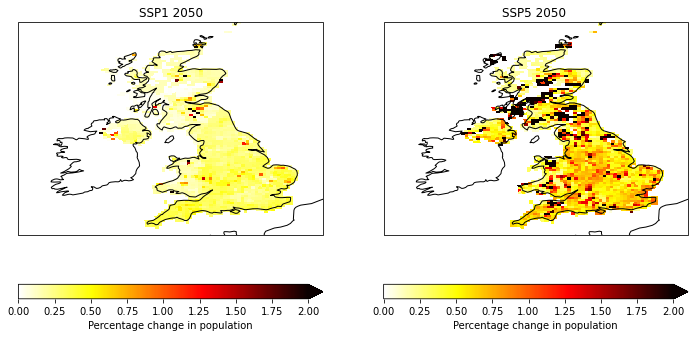

In [13]:
# plot out to check it looks ok

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([-12,3,49.5,60])
plt.pcolormesh(longitude,latitude,SSP1_2050_difference,cmap='hot_r',vmin=0,vmax=2)
c = plt.colorbar(extend='max',orientation='horizontal')
c.set_label('Percentage change in population')

plt.title('SSP1 2050')

ax = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([-12,3,49.5,60])
plt.pcolormesh(longitude,latitude,SSP5_2050_difference,cmap='hot_r',vmin=0,vmax=2)
c = plt.colorbar(extend='max',orientation='horizontal')
c.set_label('Percentage change in population')
plt.title('SSP5 2050 ')

#plt.savefig('SSP_population_growth_rates.png')
#plt.close()

In [8]:
# read in the AON data

data = read_file('/home/users/hbloomfield01/Hackathon/Hackathon_2022/',country='United Kingdom')

In [9]:
# pull relevant fields out of data frame
lat_of_buildings = np.array(data[10])
lon_of_buildings = np.array(data[11])
replacement_cost = np.array(data[2])
type_of_buildings = np.array(data[13])

In [22]:
# predefine arrays for the worlds largest loop

Total_costs_12km_array = np.zeros(np.shape(latitude))
Total_costs_12km_array_SSP1_pop = np.zeros(np.shape(latitude))
Total_costs_12km_array_SSP5_pop = np.zeros(np.shape(latitude))
Total_costs_12km_array_SSP1_urb = np.zeros(np.shape(latitude))
Total_costs_12km_array_SSP5_urb = np.zeros(np.shape(latitude))
Total_costs_12km_array_SSP1_urbpop = np.zeros(np.shape(latitude))
Total_costs_12km_array_SSP5_urbpop = np.zeros(np.shape(latitude))

SSP1_new_replacement_costs_urb = np.zeros(len(lat_of_buildings))
SSP5_new_replacement_costs_urb = np.zeros(len(lat_of_buildings))
SSP1_new_replacement_costs_pop = np.zeros(len(lat_of_buildings))
SSP5_new_replacement_costs_pop = np.zeros(len(lat_of_buildings))
SSP1_new_replacement_costs_urbpop = np.zeros(len(lat_of_buildings))
SSP5_new_replacement_costs_urbpop = np.zeros(len(lat_of_buildings))

print(datetime.now())
for point_i in range(0,len(lat_of_buildings)):
    
    
    #if type_of_buildings[point_i] == 'General residential':

    for LAT in range(0,np.shape(latitude)[0] -1):
        for LON in range(0,np.shape(latitude)[1] -1):
                                              
            if (latitude[LAT,LON] < float(lat_of_buildings[point_i]) <= latitude[LAT + 1,LON]): 
                if (longitude[LAT,LON] < float(lon_of_buildings[point_i]) <= longitude[LAT,LON +1]):

                    
                    # add the costs on within the array
                    Total_costs_12km_array[LAT,LON]  += float(replacement_cost[point_i])
                    Total_costs_12km_array_SSP1_pop[LAT,LON] += float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP1_2050_difference[LAT,LON])
                    Total_costs_12km_array_SSP5_pop[LAT,LON] += float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP5_2050_difference[LAT,LON])
                    Total_costs_12km_array_SSP1_urb[LAT,LON] += float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP1_2050_urbdifference[LAT,LON])
                    Total_costs_12km_array_SSP5_urb[LAT,LON] += float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP5_2050_urbdifference[LAT,LON])
                    Total_costs_12km_array_SSP1_urbpop[LAT,LON] += float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP1_2050_urbdifference[LAT,LON]) +  (float(replacement_cost[point_i]) * SSP1_2050_difference[LAT,LON])
                    Total_costs_12km_array_SSP5_urbpop[LAT,LON] += float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP5_2050_urbdifference[LAT,LON]) +  (float(replacement_cost[point_i]) * SSP5_2050_difference[LAT,LON])
                      
                    
                    # store lists of the new costs    
                    SSP1_new_replacement_costs_urb[point_i] = ( float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP1_2050_urbdifference[LAT,LON]))
                    SSP5_new_replacement_costs_urb[point_i] = ( float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP5_2050_urbdifference[LAT,LON]))
                    SSP1_new_replacement_costs_pop[point_i] =  (float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP1_2050_difference[LAT,LON]))
                    SSP5_new_replacement_costs_pop[point_i] =  (float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP5_2050_difference[LAT,LON]))
                    SSP1_new_replacement_costs_urbpop[point_i] =  (float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP1_2050_difference[LAT,LON])  +   (float(replacement_cost[point_i]) * SSP1_2050_urbdifference[LAT,LON]) )    
                    SSP5_new_replacement_costs_urbpop[point_i] = ( float(replacement_cost[point_i]) +  (float(replacement_cost[point_i]) * SSP5_2050_difference[LAT,LON])  +   (float(replacement_cost[point_i]) * SSP5_2050_urbdifference[LAT,LON]) )
                    
                                       
                    
print(datetime.now())
                    

2022-05-04 21:38:35.883043
2022-05-04 22:23:42.331023


NameError: name 'p' is not defined

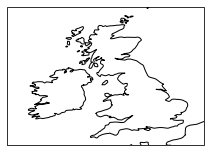

In [14]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,3,1,projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([-12,3,49.5,60])
p
plt.title('2020 Building replacement costs')
plt.pcolormesh(Total_costs_12km_array,vmin=0,vmax=1000000000,cmap='hot_r')
c = plt.colorbar()

ax = fig.add_subplot(1,3,2,projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([-12,3,49.5,60])
plt.title('2050 Building replacement costs')
plt.pcolormesh(Total_costs_12km_array_SSP5_urbpop,vmin=0,vmax=1000000000,cmap='hot_r')
c = plt.colorbar()



In [33]:
# save data so that it can be re-incoroporated into the AON data later on.

np.save('Total_costs_12km_array',Total_costs_12km_array)
np.save('Total_costs_12km_array_SSP1_pop',Total_costs_12km_array_SSP1_pop)
np.save('Total_costs_12km_array_SSP5_pop',Total_costs_12km_array_SSP5_pop)
np.save('Total_costs_12km_array_SSP1_urb',Total_costs_12km_array_SSP1_urb)
np.save('Total_costs_12km_array_SSP5_urb',Total_costs_12km_array_SSP5_urb)
np.save('Total_costs_12km_array_SSP1_urbpop',Total_costs_12km_array_SSP1_urbpop)
np.save('Total_costs_12km_array_SSP5_urbpop',Total_costs_12km_array_SSP5_urbpop)

np.save('SSP1_new_replacement_costs_urb',SSP1_new_replacement_costs_urb)
np.save('SSP5_new_replacement_costs_urb',SSP5_new_replacement_costs_urb) 
np.save('SSP1_new_replacement_costs_pop',SSP1_new_replacement_costs_pop)
np.save('SSP5_new_replacement_costs_pop',SSP5_new_replacement_costs_pop) 
np.save('SSP1_new_replacement_costs_urbpop',SSP1_new_replacement_costs_urbpop)
np.save('SSP5_new_replacement_costs_urbpop',SSP5_new_replacement_costs_urbpop)
